# Clustering and Dimension Reduction: PCA

## PCA

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px  
from sklearn.cluster import KMeans

In [5]:
df = pd.read_csv('wine.csv')
df[:5]

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [7]:
#drop wine and quality and cale
features = df.drop(columns=['quality', 'color'])  # Assuming 'quality' and 'color' are non-numeric# Standardize the features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [9]:
#PCA
pca = PCA(n_components=2)

principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [11]:
# Explained variance by each component
explained_variance = pca.explained_variance_ratio_

print(f"Explained variance by PC1: {explained_variance[0]:.2f}")
print(f"Explained variance by PC2: {explained_variance[1]:.2f}")

Explained variance by PC1: 0.28
Explained variance by PC2: 0.23


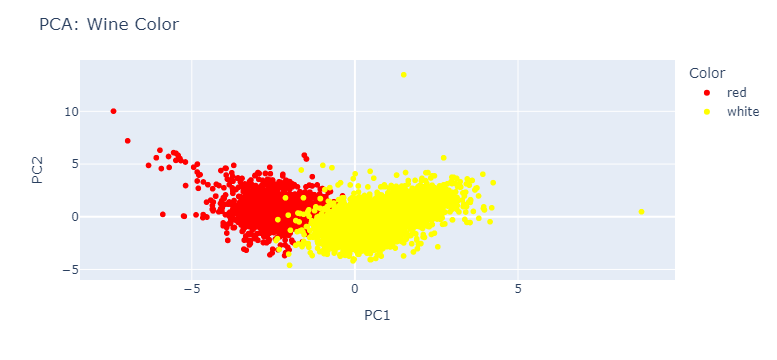

In [22]:
#add color and quality
pca_df['Color'] = df['color']
pca_df['Quality'] = df['quality']

# plot
fig = px.scatter(pca_df, 
                 x='PC1', 
                 y='PC2', 
                 color='Color', 
                 color_discrete_map={'red': 'red', 'white': 'yellow'},  # Set the color mapping
                 hover_data=['Quality'])  # Add quality as hover data# Show the plot
fig.update_layout(title="PCA: Wine Color")
fig.show()

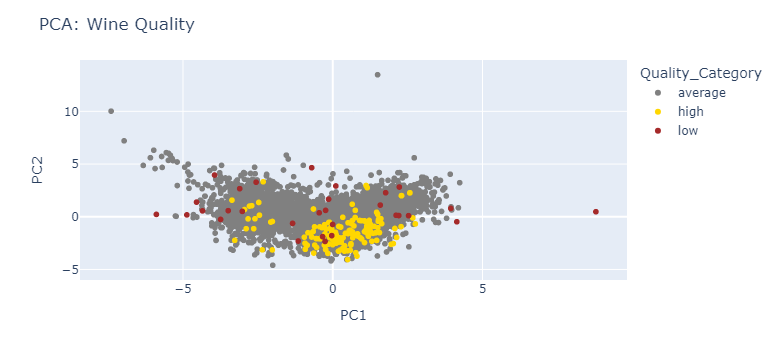

In [24]:
#wine quality groups
df['Quality_Category'] = pd.cut(df['quality'], 
                                bins=[0, 3, 7, 10], 
                                labels=['low', 'average', 'high'])

pca_df['Quality_Category'] = df['Quality_Category']

#plot for quality
fig = px.scatter(pca_df, 
                 x='PC1', 
                 y='PC2', 
                 color='Quality_Category', 
                 color_discrete_map={'low': 'brown', 'average': 'grey', 'high': 'gold'},  # Set the color mapping
                 hover_data=['Quality', 'Quality_Category'])  # Add both quality and category as hover data# Show the plot
fig.update_layout(title="PCA: Wine Quality")
fig.show()

## Clustering

### Predicting Color

In [95]:
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(pca_df[['PC1', 'PC2']])

# get the cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

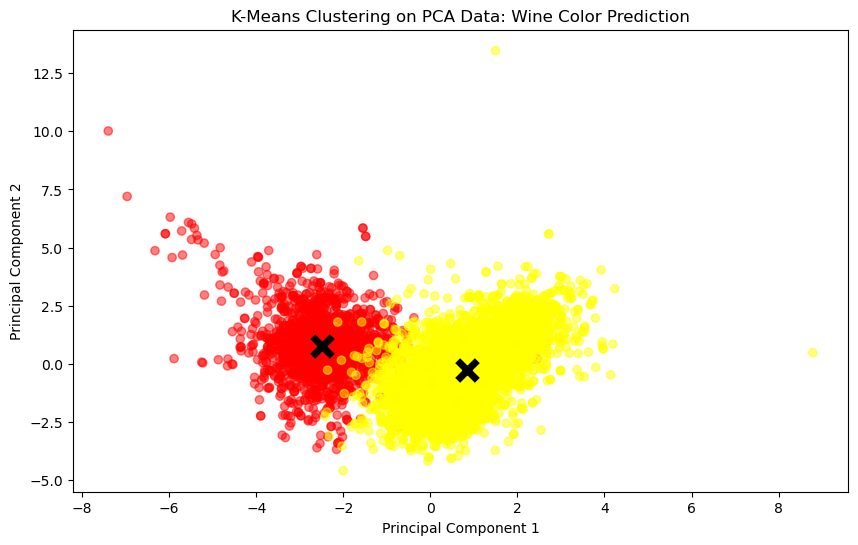

In [97]:
#plot
color_map = {'red': 'red', 'white': 'yellow'}
colors = pca_df['Color'].map(color_map)

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=colors, alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="x", s=200, linewidths=5, color='black')
plt.title('K-Means Clustering on PCA Data: Wine Color Prediction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [101]:
# Map the clusters to the actual wine colors
pca_df['Cluster'] = labels

# Determine the majority color in each cluster
cluster_0_color = 'red' if sum(pca_df[pca_df['Cluster'] == 0]['Color'] == 'red') > sum(pca_df[pca_df['Cluster'] == 0]['Color'] == 'white') else 'white'
cluster_1_color = 'red' if sum(pca_df[pca_df['Cluster'] == 1]['Color'] == 'red') > sum(pca_df[pca_df['Cluster'] == 1]['Color'] == 'white') else 'white'

# Map the clusters to the predicted colors
cluster_to_color = {0: cluster_0_color, 1: cluster_1_color}
predicted_colors = pca_df['Cluster'].map(cluster_to_color)

accuracy = accuracy_score(pca_df['Color'], predicted_colors)
print(f"K-Means Clustering Accuracy: {accuracy:.2f}")

K-Means Clustering Accuracy: 0.98


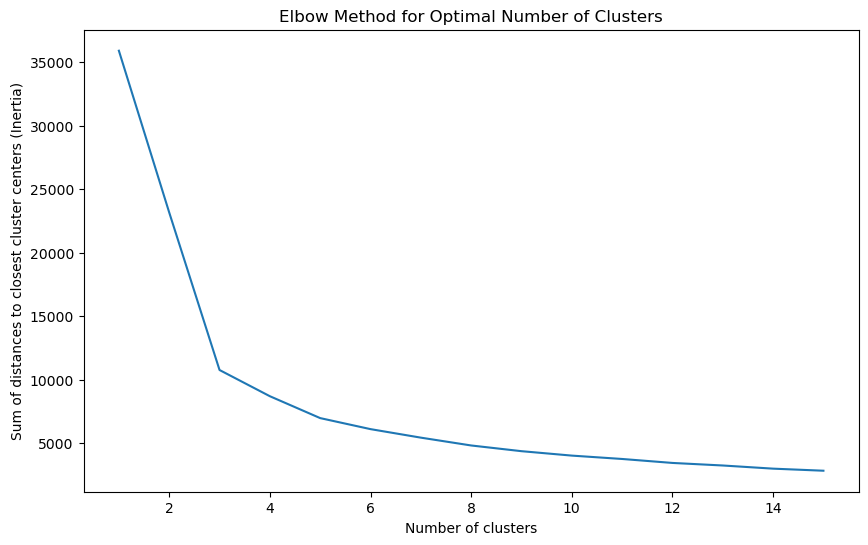

In [47]:
#check ideal number of clusters with elbow graph
sum_of_distances = {}
for num_clusters in range(1, 16):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(pca_df[['PC1', 'PC2']])
    sum_of_distances[num_clusters] = kmeans.inertia_

plt.figure(figsize=(10, 6))
pd.Series(sum_of_distances).sort_index().plot()
plt.xlabel('Number of clusters')
plt.ylabel('Sum of distances to closest cluster centers (Inertia)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

### Predicting Quality

In [50]:
#cluster!
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(pca_df[['PC1', 'PC2']])

# Get the cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

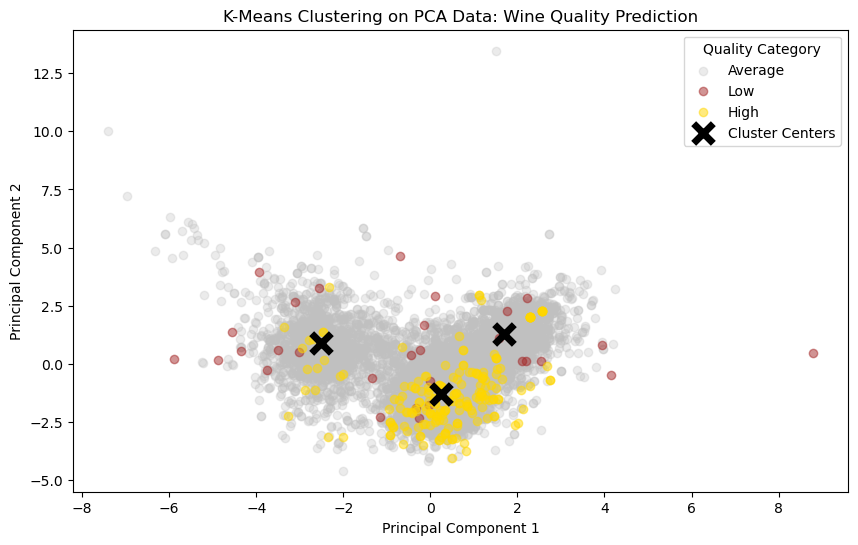

In [62]:
# Map colors
color_map = {'low': 'brown', 'average': 'silver', 'high': 'gold'}
colors = df['Quality_Category'].map(color_map)

#plot
plt.figure(figsize=(10, 6))

average_points = pca_df[df['Quality_Category'] == 'average']
plt.scatter(average_points['PC1'], average_points['PC2'], 
            c=color_map['average'], alpha=0.3, label='Average')

for quality in ['low', 'high']:
    category_points = pca_df[df['Quality_Category'] == quality]
    plt.scatter(category_points['PC1'], category_points['PC2'], 
                c=color_map[quality], alpha=0.5, label=quality.capitalize())

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
            marker="x", s=200, linewidths=5, color='black', label='Cluster Centers')

plt.legend(title='Quality Category')
plt.title('K-Means Clustering on PCA Data: Wine Quality Prediction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Now, let's test for accuracy on color

In [83]:
from sklearn.model_selection import train_test_split

X = pca_df[['PC1', 'PC2']]
y = pca_df['Color']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [85]:
# Calculate the baseline accuracy
baseline_accuracy = max(y_test.value_counts()) / len(y_test)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.77


In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

#train
kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(X_train)

#predict
kmeans_labels = kmeans.predict(X_test)

# Determine the majority actual color in each cluster
actual_labels = np.array(y_test)
cluster_0_majority = 'red' if sum(actual_labels[kmeans_labels == 0] == 'red') > sum(actual_labels[kmeans_labels == 0] == 'white') else 'white'
cluster_1_majority = 'red' if sum(actual_labels[kmeans_labels == 1] == 'red') > sum(actual_labels[kmeans_labels == 1] == 'white') else 'white'# Create a dictionary to map clusters to colors
cluster_to_color = {0: cluster_0_majority, 1: cluster_1_majority}

# Assign the predicted colors based on the cluster-to-color mapping
predicted_colors = [cluster_to_color[label] for label in kmeans_labels]

#calculate the accuracy
kmeans_accuracy = accuracy_score(y_test, predicted_colors)
print(f"K-Means Clustering Accuracy: {kmeans_accuracy:.2f}")

K-Means Clustering Accuracy: 0.98


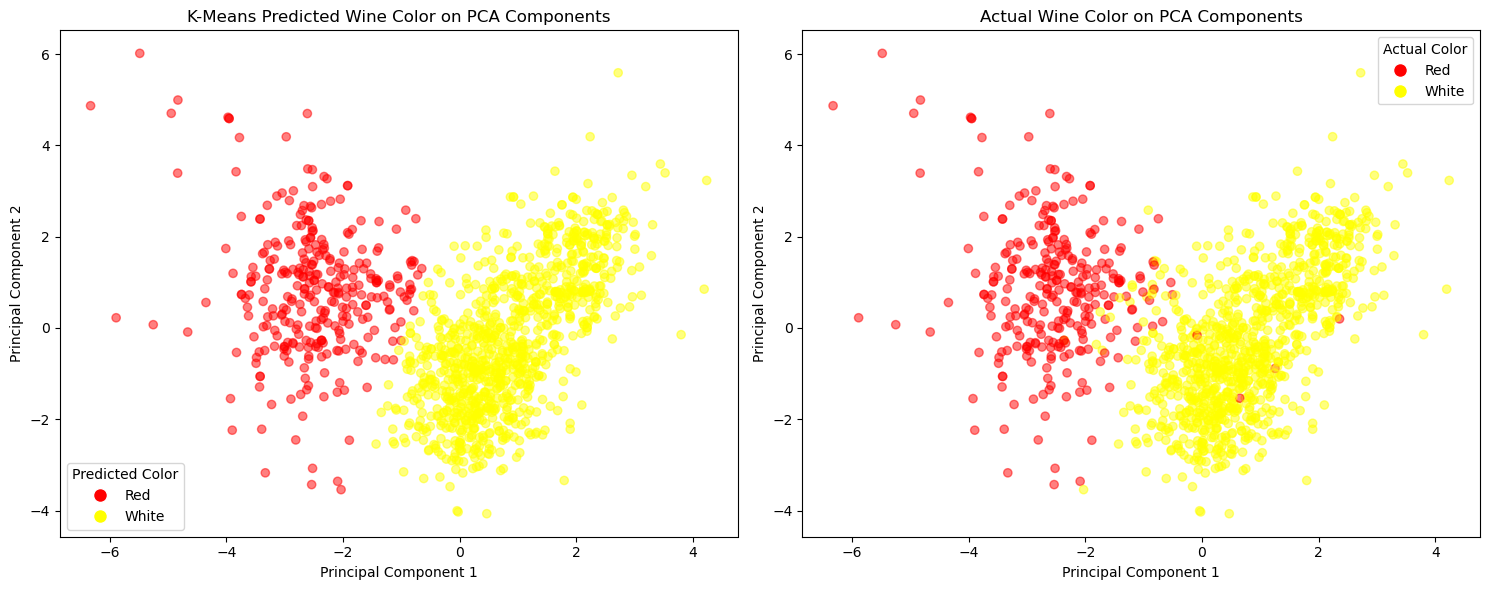

In [93]:

# Map the actual colors
actual_color_map = {'red': 'red', 'white': 'yellow'}
actual_colors_mapped = [actual_color_map[color] for color in y_test]

# Map the predicted colors
predicted_color_map = {'red': 'red', 'white': 'yellow'}
predicted_colors_mapped = [predicted_color_map[color] for color in predicted_colors]

#plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#predicted plot
axes[0].scatter(X_test['PC1'], X_test['PC2'], c=predicted_colors_mapped, alpha=0.5)
axes[0].set_title('K-Means Predicted Wine Color on PCA Components')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

#actual plot
axes[1].scatter(X_test['PC1'], X_test['PC2'], c=actual_colors_mapped, alpha=0.5)
axes[1].set_title('Actual Wine Color on PCA Components')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Red'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='White')]
axes[0].legend(title='Predicted Color', handles=handles)
axes[1].legend(title='Actual Color', handles=handles)

plt.tight_layout()
plt.show()